<a href="https://colab.research.google.com/github/ConanOReilly/Final_Year_Project/blob/main/Multi_Modal_Predictions/SiameseSwinV2MAFCL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Swin V2 MAF Model with Siamese Network**
A siamese network was implemented to try help make improvements in under represented classes in the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from tqdm import tqdm
from transformers import Swinv2Model
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Siamese Dataset**

In [ ]:
class SiamesePADUFESDataset(Dataset):
    def __init__(self, dataframe, img_dir, metadata_cols, augment=True):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.metadata_cols = metadata_cols
        self.augment = augment

        self.label_dict = {label: idx for idx, label in enumerate(sorted(self.df['diagnostic'].unique()))}
        self.df['label_encoded'] = self.df['diagnostic'].map(self.label_dict)

        self.label_to_indices = {label: self.df[self.df['diagnostic'] == label].index.tolist()
                                 for label in self.df['diagnostic'].unique()}

        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

        self.base_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row1 = self.df.iloc[idx]
        label1 = row1['diagnostic']

        if random.random() < 0.5:
            idx2 = random.choice(self.label_to_indices[label1])
            label = 1
        else:
            label2 = random.choice([l for l in self.label_to_indices if l != label1])
            idx2 = random.choice(self.label_to_indices[label2])
            label = 0

        row2 = self.df.iloc[idx2]

        def load(row):
            img = Image.open(os.path.join(self.img_dir, row['img_id'])).convert("RGB")
            img = self.transform(img) if self.augment else self.base_transform(img)
            meta_values = row[self.metadata_cols].astype(float).values.astype(np.float32)
            meta = torch.tensor(meta_values, dtype=torch.float32)
            return img, meta

        img1, meta1 = load(row1)
        img2, meta2 = load(row2)

        return (img1, meta1), (img2, meta2), torch.tensor(label, dtype=torch.float32), row1['label_encoded']

# **Defining Model**

In [ ]:
class ModalityAttentionFusion(nn.Module):
    def __init__(self, dim_img, dim_meta):
        super().__init__()
        self.attn_layer = nn.Sequential(
            nn.Linear(dim_img + dim_meta, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, img_feat, meta_feat):
        combined = torch.cat([img_feat, meta_feat], dim=1)
        attn_weights = self.attn_layer(combined)
        img_alpha = attn_weights[:, 0].unsqueeze(1)
        meta_alpha = attn_weights[:, 1].unsqueeze(1)
        return img_alpha * img_feat + meta_alpha * meta_feat

In [ ]:
class MultiModalSwinClassifier(nn.Module):
    def __init__(self, num_classes, metadata_dim):
        super().__init__()
        self.image_model = Swinv2Model.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
        self.image_fc = nn.Sequential(
            nn.Linear(self.image_model.config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.metadata_fc = nn.Sequential(
            nn.Linear(metadata_dim, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            nn.Dropout(0.3),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )
        self.fusion = ModalityAttentionFusion(128, 128)
        self.classifier = nn.Identity()

    def forward(self, image, metadata):
        image_features = self.image_model(image).pooler_output
        image_features = self.image_fc(image_features)
        metadata_features = self.metadata_fc(metadata)
        fused = self.fusion(image_features, metadata_features)
        return fused

In [ ]:
class SiameseMultiModalNetwork(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.backbone = base_model

    def forward_once(self, img, meta):
        return self.backbone(img, meta)

    def forward(self, img1, meta1, img2, meta2):
        out1 = self.forward_once(img1, meta1)
        out2 = self.forward_once(img2, meta2)
        return out1, out2

# **Contrastive Loss**

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, out1, out2, label):
        dist = F.pairwise_distance(out1, out2)
        loss = label * dist.pow(2) + (1 - label) * F.relu(self.margin - dist).pow(2)
        return loss.mean()

# **Training Loop**

In [ ]:
def train_siamese(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for (img1, meta1), (img2, meta2), label, _ in tqdm(loader, desc="Training"):
        img1, img2 = img1.to(device), img2.to(device)
        meta1, meta2 = meta1.to(device), meta2.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        out1, out2 = model(img1, meta1, img2, meta2)
        loss = criterion(out1, out2, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

In [ ]:
def validate_siamese(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for (img1, meta1), (img2, meta2), label, _ in loader:
            img1, img2 = img1.to(device), img2.to(device)
            meta1, meta2 = meta1.to(device), meta2.to(device)
            label = label.to(device)

            out1, out2 = model(img1, meta1, img2, meta2)
            loss = criterion(out1, out2, label)
            total_loss += loss.item()

    return total_loss / len(loader)

# **Loading Data**

In [ ]:
!mkdir -p /content/PAD_imgs
!cp -r "/content/drive/MyDrive/Final Year Project/Data/PAD/imgs"/* /content/PAD_imgs
img_dir = "/content/PAD_imgs"

In [ ]:
!ls /content/PAD_imgs | wc -l

2298


In [ ]:
train_csv = "/content/drive/MyDrive/Final Year Project/Code/MetaBlock/Data/pad-ufes-20_parsed_folders.csv"
test_csv = "/content/drive/MyDrive/Final Year Project/Code/MetaBlock/Data/pad-ufes-20_parsed_test.csv"

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

exclude_cols = ['img_id', 'diagnostic', 'patient_id', 'lesion_id', 'folder', 'diagnostic_number', 'label_encoded']
metadata_cols = [col for col in train_df.columns if col not in exclude_cols]

scaler = StandardScaler()
train_df[metadata_cols] = scaler.fit_transform(train_df[metadata_cols])
test_df[metadata_cols] = scaler.transform(test_df[metadata_cols])

train_ds = SiamesePADUFESDataset(train_df, img_dir="/content/PAD_imgs", metadata_cols=metadata_cols, augment=True)
val_ds   = SiamesePADUFESDataset(test_df, img_dir="/content/PAD_imgs", metadata_cols=metadata_cols, augment=False)

train_loader = DataLoader(train_ds, batch_size=12, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=12, shuffle=False)

# **Training Model**

In [ ]:
base_model = MultiModalSwinClassifier(num_classes=0, metadata_dim=len(metadata_cols))
model = SiameseMultiModalNetwork(base_model).to(device)

criterion = ContrastiveLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/113M [00:00<?, ?B/s]

In [ ]:
best_val_loss = float("inf")
epochs_no_improve = 0
patience = 5
save_path = "/content/drive/MyDrive/Final Year Project/Code/Siamese Network/Paths/siamese_best_model.pth"

for epoch in range(25):
    train_loss = train_siamese(model, train_loader, criterion, optimizer, device)

    val_loss = validate_siamese(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), save_path)
        print(f"Saved best model to {save_path}")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Training: 100%|██████████| 160/160 [04:17<00:00,  1.61s/it]


Epoch 01 | Train Loss: 0.5978 | Val Loss: 0.2383
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Siamese Network/Paths/siamese_best_model.pth


Training: 100%|██████████| 160/160 [03:56<00:00,  1.48s/it]


Epoch 02 | Train Loss: 0.2459 | Val Loss: 0.2284
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Siamese Network/Paths/siamese_best_model.pth


Training: 100%|██████████| 160/160 [03:53<00:00,  1.46s/it]


Epoch 03 | Train Loss: 0.2395 | Val Loss: 0.2260
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Siamese Network/Paths/siamese_best_model.pth


Training: 100%|██████████| 160/160 [03:51<00:00,  1.45s/it]


Epoch 04 | Train Loss: 0.2349 | Val Loss: 0.2178
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Siamese Network/Paths/siamese_best_model.pth


Training: 100%|██████████| 160/160 [03:55<00:00,  1.47s/it]


Epoch 05 | Train Loss: 0.2300 | Val Loss: 0.2107
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Siamese Network/Paths/siamese_best_model.pth


Training: 100%|██████████| 160/160 [03:50<00:00,  1.44s/it]


Epoch 06 | Train Loss: 0.2231 | Val Loss: 0.2056
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Siamese Network/Paths/siamese_best_model.pth


Training: 100%|██████████| 160/160 [03:53<00:00,  1.46s/it]


Epoch 07 | Train Loss: 0.2196 | Val Loss: 0.2065
No improvement for 1 epoch(s)


Training: 100%|██████████| 160/160 [03:52<00:00,  1.45s/it]


Epoch 08 | Train Loss: 0.2126 | Val Loss: 0.1989
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Siamese Network/Paths/siamese_best_model.pth


Training: 100%|██████████| 160/160 [03:52<00:00,  1.45s/it]


Epoch 09 | Train Loss: 0.2112 | Val Loss: 0.1815
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Siamese Network/Paths/siamese_best_model.pth


Training: 100%|██████████| 160/160 [03:52<00:00,  1.46s/it]


Epoch 10 | Train Loss: 0.2035 | Val Loss: 0.1818
No improvement for 1 epoch(s)


Training: 100%|██████████| 160/160 [03:55<00:00,  1.47s/it]


Epoch 11 | Train Loss: 0.2024 | Val Loss: 0.1786
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Siamese Network/Paths/siamese_best_model.pth


Training: 100%|██████████| 160/160 [03:52<00:00,  1.45s/it]


Epoch 12 | Train Loss: 0.1930 | Val Loss: 0.1766
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Siamese Network/Paths/siamese_best_model.pth


Training: 100%|██████████| 160/160 [03:52<00:00,  1.46s/it]


Epoch 13 | Train Loss: 0.1927 | Val Loss: 0.1636
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Siamese Network/Paths/siamese_best_model.pth


Training: 100%|██████████| 160/160 [03:51<00:00,  1.45s/it]


Epoch 14 | Train Loss: 0.1916 | Val Loss: 0.1894
No improvement for 1 epoch(s)


Training: 100%|██████████| 160/160 [03:55<00:00,  1.47s/it]


Epoch 15 | Train Loss: 0.1827 | Val Loss: 0.1670
No improvement for 2 epoch(s)


Training: 100%|██████████| 160/160 [03:48<00:00,  1.43s/it]


Epoch 16 | Train Loss: 0.1811 | Val Loss: 0.1648
No improvement for 3 epoch(s)


Training: 100%|██████████| 160/160 [03:48<00:00,  1.43s/it]


Epoch 17 | Train Loss: 0.1763 | Val Loss: 0.1711
No improvement for 4 epoch(s)


Training: 100%|██████████| 160/160 [03:45<00:00,  1.41s/it]


Epoch 18 | Train Loss: 0.1750 | Val Loss: 0.1839
No improvement for 5 epoch(s)
Early stopping triggered at epoch 18


# **t-SNE of Siamese Embeddings**

In [ ]:
def get_embeddings_from_siamese(dataloader, model):
    model.eval()
    all_embeds, all_true_labels = [], []
    with torch.no_grad():
        for (img1, meta1), (_, _), _, true_label in tqdm(dataloader, desc="Extracting Embeddings"):
            img1, meta1 = img1.to(device), meta1.to(device)
            embed = model.forward_once(img1, meta1)
            all_embeds.append(embed.cpu())
            all_true_labels.extend(true_label.cpu().tolist())
    return torch.cat(all_embeds), torch.tensor(all_true_labels)

In [ ]:
sample = train_ds[0]
print(f"Sample returned: {len(sample)} elements")

Sample returned: 4 elements


In [ ]:
embeds, labels = get_embeddings_from_siamese(val_loader, model)
embeds_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(embeds)

Extracting Embeddings: 100%|██████████| 32/32 [00:32<00:00,  1.01s/it]


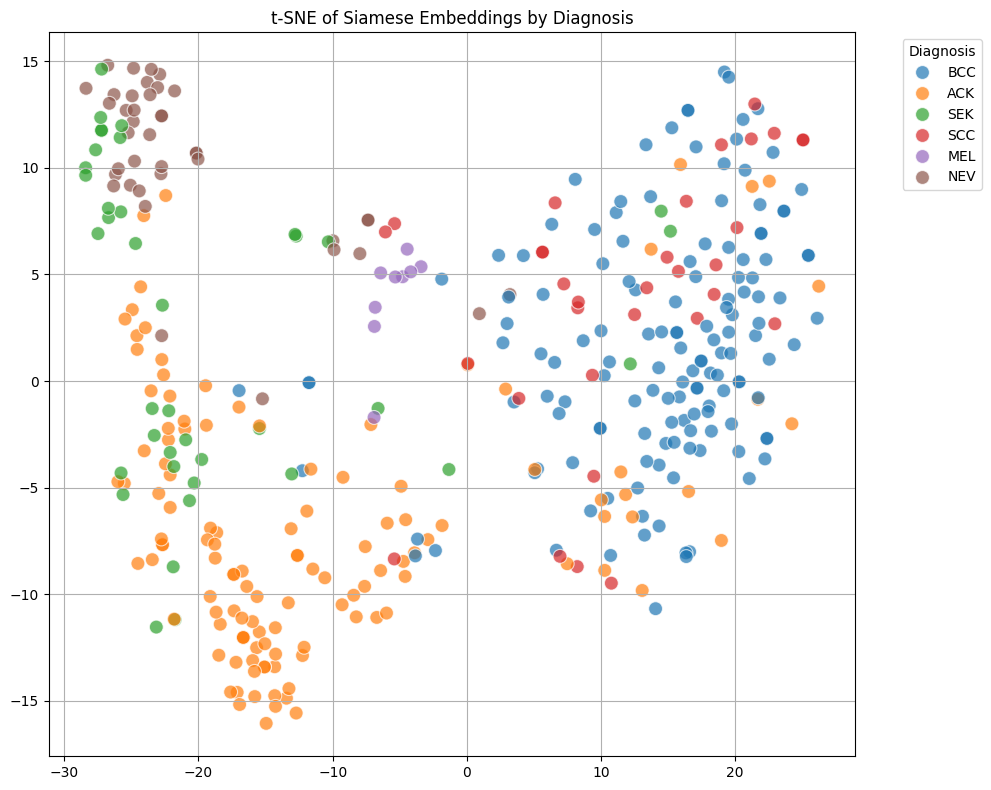

In [ ]:
label_dict = val_ds.label_dict
inv_label_dict = {v: k for k, v in label_dict.items()}

label_names = [inv_label_dict[int(l)] for l in labels.numpy()]

plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeds_2d[:, 0], y=embeds_2d[:, 1], hue=label_names, palette="tab10", s=100, alpha=0.7)
plt.title("t-SNE of Siamese Embeddings by Diagnosis")
plt.legend(title="Diagnosis", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
val_embeds, val_labels = get_embeddings_from_siamese(val_loader, model)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(embeds.numpy(), labels.numpy())
val_preds = knn.predict(val_embeds.numpy())

print(classification_report(val_labels.numpy(), val_preds, target_names=list(inv_label_dict.values())))

Extracting Embeddings: 100%|██████████| 32/32 [00:47<00:00,  1.50s/it]

              precision    recall  f1-score   support

         ACK       0.73      0.89      0.80       122
         BCC       0.83      0.89      0.86       141
         MEL       1.00      0.89      0.94         9
         NEV       0.88      0.90      0.89        40
         SCC       0.69      0.34      0.46        32
         SEK       0.95      0.46      0.62        39

    accuracy                           0.80       383
   macro avg       0.85      0.73      0.76       383
weighted avg       0.81      0.80      0.79       383

